# rACS in Real-Multiplexer

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.30327608954227625, 0.12327371114222807, 0.7414736556310513, 0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[0, 0, 1, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## rACS

- write abount _encoders_

In [7]:
def encode(bits, val):
    return int(RealValueEncoder(bits).encode(val))

r = np.arange(0, 1.1, .1)

df = pd.DataFrame(r, columns=['Perception'])

for bit in [1, 2, 3, 4, 5, 6, 7]:
    df[f'{bit}-bit'] = df.apply(lambda row: encode(bit, row['Perception']), axis=1)

df.set_index('Perception', inplace=True)
df

,1-bit,2-bit,3-bit,4-bit,5-bit,6-bit,7-bit
Perception,,,,,,,
0.0,0,0,0,0,0,0,0
0.1,0,0,1,2,3,6,13
0.2,0,1,1,3,6,13,25
0.3,0,1,2,5,9,19,38
0.4,0,1,3,6,12,25,51
0.5,0,2,4,8,16,32,64
0.6,1,2,4,9,19,38,76
0.7,1,2,5,11,22,44,89
0.8,1,2,6,12,25,50,102


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [8]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()]),
    }

Define a function for executing experiments

In [9]:
def perform_experiment(env, encoder_bits, trials):
    # create configuration
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(encoder_bits),
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    chi=0.5,  # cross-over probability
                    mu=0.1)  # mutation probability
    
    # create agent
    agent = RACS(cfg)
    
    # run computations
    population, metrics = agent.explore_exploit(env, trials)
    
    return population, metrics

## Data visualization

In [11]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

In [12]:
def plot_results(metrics, env, encoder_bits):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}, ubr encoder bits: {encoder_bits}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    ax2.legend()

## rMPX results

In [13]:
# Define experiment constants
rmpx = gym.make('real-multiplexer-3bit-v0')

In [14]:
def evaluate(rmpx, encoder_bits, trials=10_000):
    population, metrics = perform_experiment(rmpx, encoder_bits=encoder_bits, trials=trials)
    plot_results(metrics, rmpx, encoder_bits)

INFO:lcs.agents.racs.RACS:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.racs.RACS:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 10, 'numerosity': 160, 'reliable': 10}


CPU times: user 10.4 s, sys: 165 ms, total: 10.6 s
Wall time: 10.9 s


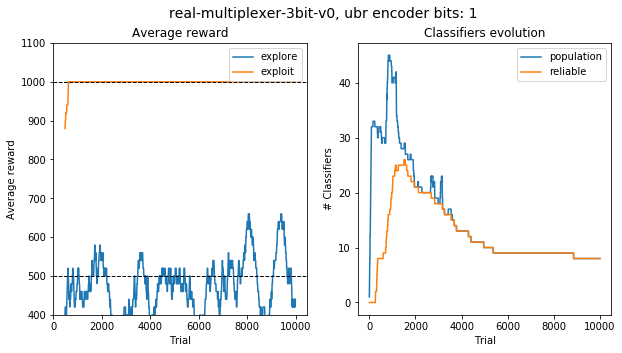

In [22]:
%%time
evaluate(rmpx, encoder_bits=1, trials=10_000)

INFO:lcs.agents.racs.RACS:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.racs.RACS:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 95, 'numerosity': 627, 'reliable': 49}
INFO:lcs.agents.racs.RACS:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 32, 'numerosity': 640, 'reliable': 32}


CPU times: user 36.9 s, sys: 619 ms, total: 37.5 s
Wall time: 39 s


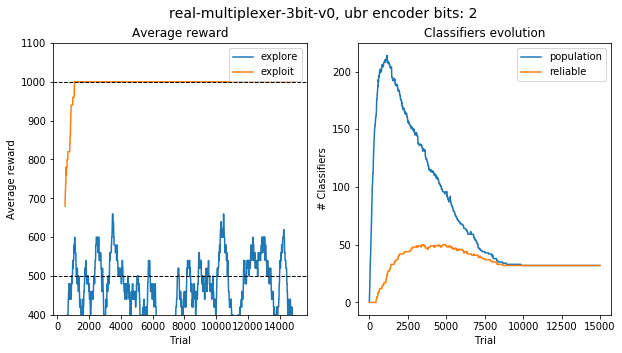

In [21]:
%%time
evaluate(rmpx, encoder_bits=2, trials=15_000)

INFO:lcs.agents.racs.RACS:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.racs.RACS:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 1338, 'numerosity': 2059, 'reliable': 36}


CPU times: user 4min 39s, sys: 2.97 s, total: 4min 42s
Wall time: 4min 50s


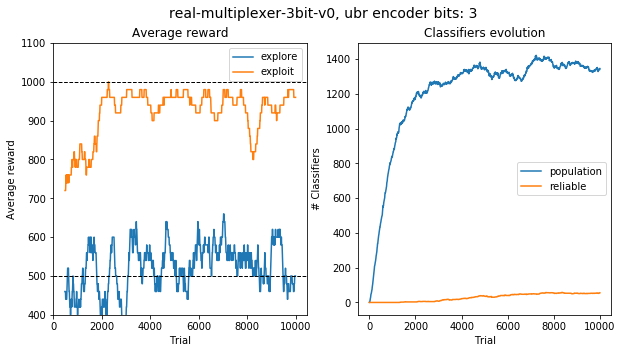

In [17]:
%%time
evaluate(rmpx, encoder_bits=3, trials=20_000)

INFO:lcs.agents.racs.RACS:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.racs.RACS:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 3506, 'numerosity': 4677, 'reliable': 0}
INFO:lcs.agents.racs.RACS:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 4252, 'numerosity': 6057, 'reliable': 26}
INFO:lcs.agents.racs.RACS:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 4973, 'numerosity': 7453, 'reliable': 58}
INFO:lcs.agents.racs.RACS:{'trial': 20000, 'steps_in_trial': 1, 'reward': 0, 'population': 5656, 'numerosity': 8965, 'reliable': 79}
INFO:lcs.agents.racs.RACS:{'trial': 25000, 'steps_in_trial': 1, 'reward': 1000, 'population': 5923, 'numerosity': 9779, 'reliable': 105}
INFO:lcs.agents.racs.RACS:{'trial': 30000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6372, 'numerosity': 10895, 'reliable': 116}
INFO:lcs.agents.racs.RACS:{'trial': 35000, 'steps_in_trial': 1, 'rewar

CPU times: user 1h 19min, sys: 55.6 s, total: 1h 19min 56s
Wall time: 1h 28min 18s


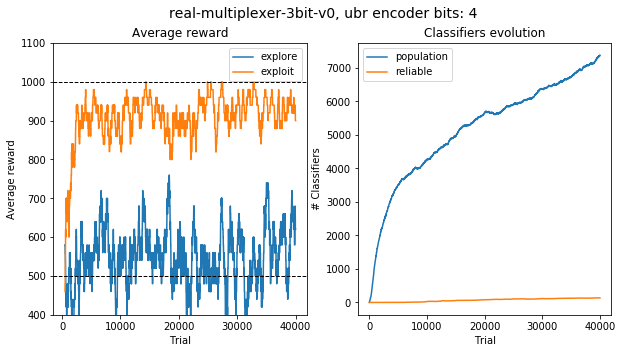

In [20]:
%%time
evaluate(rmpx, encoder_bits=4, trials=40_000)

In [19]:
# %%time
# evaluate(rmpx, encoder_bits=5)